<a href="https://colab.research.google.com/github/JuanZapa7a/semiotics/blob/main/QAT_MNIST_NOISY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installation of Larq and necessary dependencies

In [ ]:
!pip -q install tensorflow==2.10.0
!pip -q install larq==0.13.1

import tensorflow as tf
import larq as lq

## 2. Data preparation (MNIST)

Download and prepare the MNIST dataset.

By default, each MNIST image has a shape of (28, 28), which is 2D.
However, neural networks (especially convolutional networks) typically expect 3D inputs: (height, width, channels).
Adding a channel dimension (with value 1 for grayscale) changes each image shape from (28, 28) to (28, 28, 1), which is required for most neural network layers to interpret the images correctly.
The overall shapes for the dataset become (60000, 28, 28, 1) for training and (10000, 28, 28, 1) for testing.

The MNIST dataset’s pixel values originally range from 0 to 255.
Dividing by 127.5 and then subtracting 1 maps the values to a -1 to 1 range, which can help certain models converge more quickly and maintain numerical stability. (Centering pixel values around zero often benefits neural networks as it reduces bias and helps gradient-based methods perform better.)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)) # (60000, 28, 28) (60000,)
test_images = test_images.reshape((10000, 28, 28, 1)) # (10000, 28, 28) (10000,)

# For binarized models, it is standard to normalize images to a range between -1 and 1.
train_images, test_images = train_images / 127.5 - 1,test_images / 127.5 - 1

print(train_images.shape, train_labels.shape)  # Debe ser (60000, 28, 28, 1), (60000,)
print(test_images.shape, test_labels.shape)    # Debe ser (10000, 28, 28, 1), (10000,)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


## 5. Creation of a binarized model

The following will create a simple binarized CNN.

The quantization function
$$
q(x) = \begin{cases}
    -1 & x < 0 \\\
    1 & x \geq 0
\end{cases}
$$
is used in the forward pass to binarize the activations and the latent full precision weights. The gradient of this function is zero almost everywhere which prevents the model from learning.

To be able to train the model the gradient is instead estimated using the Straight-Through Estimator (STE)
(the binarization is essentially replaced by a clipped identity on the backward pass):
$$
\frac{\partial q(x)}{\partial x} = \begin{cases}
    1 & \left|x\right| \leq 1 \\\
    0 & \left|x\right| > 1
\end{cases}
$$

In Larq this can be done by using `input_quantizer="ste_sign"` and `kernel_quantizer="ste_sign"`.
Additionally, the latent full precision weights are clipped to -1 and 1 using `kernel_constraint="weight_clip"`.

```python
import larq as lq
import tensorflow as tf

# Define default quantization options for all layers except the first layer
kwargs = dict(
    input_quantizer="ste_sign",      # Quantizes activations using Sign-STE (binary quantization to -1 or +1)
    kernel_quantizer="ste_sign",     # Quantizes weights to binary values (-1 or +1) with Sign-STE
    kernel_constraint="weight_clip"  # Clips weights within a set range (typically -1 to +1) to stabilize training
)

# Initialize a Sequential model
model = tf.keras.models.Sequential()

# First layer: Quantized convolutional layer (only quantizing weights, not inputs)
model.add(lq.layers.QuantConv2D(
    32, (3, 3),                      # 32 filters of size 3x3
    kernel_quantizer="ste_sign",     # Quantize weights to -1 or +1
    kernel_constraint="weight_clip", # Restrict weights to a range for stability
    use_bias=False,                  # Disable bias for simplicity
    input_shape=(28, 28, 1)          # Input shape for MNIST (28x28 grayscale images)
))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample with max pooling
model.add(tf.keras.layers.BatchNormalization(scale=False)) # Batch normalization to stabilize activations

# Second quantized convolutional layer (quantizes both weights and activations)
model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample again
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Third quantized convolutional layer (also quantizes both weights and activations)
model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())                    # Flatten the output for fully connected layers

# Quantized dense (fully connected) layer with 64 units
model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Final quantized dense layer for output (10 classes for MNIST)
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))        # Softmax activation for classification probabilities

lq.models.summary(model)

```

To add noise to the weights in your model's layers, you can create a custom layer that wraps the original layers and modifies the weights during training. Here's how you can modify your code to inject noise into the weights:

### Modified code to add noise to the weights


### Explanation of Changes:
1. **`NoisyLayer` class**: This custom layer wraps an existing layer, such as `QuantConv2D` or `QuantDense`, and adds noise to its weights during training. The noise is Gaussian with a standard deviation defined by `noise_stddev`.
2. **Adding noise**: Noise is added directly to the trainable weights using `assign_add`. This affects the weights during the forward pass.
3. **Integration in the model**: All relevant layers are wrapped with instances of `NoisyLayer`.


**Note**: The primary reason to use only the standard deviation (𝜎) when modeling noise in neural networks is that most common noise sources in hardware, like thermal or electronic noise, are typically assumed to follow a Gaussian distribution (normal distribution) with a mean (𝜇) of zero.

In [ ]:
import larq as lq
import tensorflow as tf

# Define a custom layer to add noise to weights
class NoisyLayer(tf.keras.layers.Layer):
    def __init__(self, wrapped_layer, noise_mean=0.0, noise_stddev=0.01, **kwargs):
        super().__init__(**kwargs)
        self.wrapped_layer = wrapped_layer  # Original layer to wrap
        self.noise_mean = noise_mean        # Mean of the noise
        self.noise_stddev = noise_stddev    # Standard deviation of the noise

    def call(self, inputs):
        # Apply noise during both training and validation
        for weight in self.wrapped_layer.trainable_weights:
            noise = tf.random.normal(
                shape=tf.shape(weight),
                mean=self.noise_mean,
                stddev=self.noise_stddev
            )
            noisy_weight = weight + noise  # Add noise to weights
            # Apply the noisy weight to the layer
            weight.assign(noisy_weight)  # Assign the noisy weights directly

        return self.wrapped_layer(inputs)  # Apply the layer logic

# Define default quantization options for quantized layers
kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
)

# Initialize a Sequential model
model = tf.keras.models.Sequential()

# First convolutional layer with noise on weights
model.add(NoisyLayer(
    lq.layers.QuantConv2D(
        32, (3, 3),                      # 32 filters of size 3x3
        kernel_quantizer="ste_sign",     # Quantize weights to -1 or +1
        kernel_constraint="weight_clip", # Restrict weights to a range for stability
        use_bias=False,                  # Disable bias for simplicity
        input_shape=(28, 28, 1)          # Input shape for MNIST (28x28 grayscale images)
        ),
    noise_stddev=0.01  # Standard deviation of noise
))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))             # Downsample with max pooling
model.add(tf.keras.layers.BatchNormalization(scale=False))  # Batch normalization to stabilize activations

# Second convolutional layer with noise on weights
model.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev=0.01
))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Third convolutional layer with noise on weights
model.add(NoisyLayer(
    lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs),
    noise_stddev=0.01
))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())

# Dense layer with noise on weights
model.add(NoisyLayer(
    lq.layers.QuantDense(64, use_bias=False, **kwargs),
    noise_stddev=0.01
))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer with noise on weights
model.add(NoisyLayer(
    lq.layers.QuantDense(10, use_bias=False, **kwargs),
    noise_stddev=0.01
))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))

In [ ]:
# Display the model summary
# Build the model before getting the summary
model.build(input_shape=(None, 28, 28, 1))  # Specify input shape to build the model

lq.models.summary(model)

+sequential_2 stats----------------------------------------------------------------+
| Layer                   Input prec.           Outputs  # 1-bit  # 32-bit  Memory |
|                               (bit)                        x 1       x 1    (kB) |
+----------------------------------------------------------------------------------+
| noisy_layer_5                     -  (-1, 26, 26, 32)      288         0    0.04 |
| max_pooling2d_4                   -  (-1, 13, 13, 32)        0         0       0 |
| batch_normalization_10            -  (-1, 13, 13, 32)        0        64    0.25 |
| noisy_layer_6                     -  (-1, 11, 11, 64)    18432         0    2.25 |
| max_pooling2d_5                   -    (-1, 5, 5, 64)        0         0       0 |
| batch_normalization_11            -    (-1, 5, 5, 64)        0       128    0.50 |
| noisy_layer_7                     -    (-1, 3, 3, 64)    36864         0    4.50 |
| batch_normalization_12            -    (-1, 3, 3, 64)        0 

In [ ]:
# Compile the model with an optimizer and loss function
model.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history = model.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels) # Evaluate on test set after each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 88s 92ms/step - loss: 1.1008 - accuracy: 0.7375 - val_loss: 1.3412 - val_accuracy: 0.6548
Epoch 2/6
938/938 [==============================] - 73s 77ms/step - loss: 0.8370 - accuracy: 0.8490 - val_loss: 0.8724 - val_accuracy: 0.8557
Epoch 3/6
938/938 [==============================] - 72s 77ms/step - loss: 0.7246 - accuracy: 0.8926 - val_loss: 0.8366 - val_accuracy: 0.8675
Epoch 4/6
938/938 [==============================] - 71s 76ms/step - loss: 0.6556 - accuracy: 0.9132 - val_loss: 0.6869 - val_accuracy: 0.9066
Epoch 5/6
938/938 [==============================] - 71s 76ms/step - loss: 0.6148 - accuracy: 0.9266 - val_loss: 0.6895 - val_accuracy: 0.9280
Epoch 6/6
313/313 [==============================] - 4s 13ms/step - loss: 0.9586 - accuracy: 0.8388
Test Accuracy: 83.88%
Test Loss: 0.9586


In [ ]:
import larq as lq
import tensorflow as tf

# Define default quantization options for all layers except the first layer
kwargs = dict(
    input_quantizer="ste_sign",      # Quantizes activations using Sign-STE (binary quantization to -1 or +1)
    kernel_quantizer="ste_sign",     # Quantizes weights to binary values (-1 or +1) with Sign-STE
    kernel_constraint="weight_clip"  # Clips weights within a set range (typically -1 to +1) to stabilize training
)

# Initialize a Sequential model
model_b = tf.keras.models.Sequential()

# First layer: Quantized convolutional layer (only quantizing weights, not inputs)
model_b.add(lq.layers.QuantConv2D(
    32, (3, 3),                      # 32 filters of size 3x3
    kernel_quantizer="ste_sign",     # Quantize weights to -1 or +1
    kernel_constraint="weight_clip", # Restrict weights to a range for stability
    use_bias=False,                  # Disable bias for simplicity
    input_shape=(28, 28, 1)          # Input shape for MNIST (28x28 grayscale images)
))
model_b.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample with max pooling
model_b.add(tf.keras.layers.BatchNormalization(scale=False)) # Batch normalization to stabilize activations

# Second quantized convolutional layer (quantizes both weights and activations)
model_b.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model_b.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample again
model_b.add(tf.keras.layers.BatchNormalization(scale=False))

# Third quantized convolutional layer (also quantizes both weights and activations)
model_b.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model_b.add(tf.keras.layers.BatchNormalization(scale=False))
model_b.add(tf.keras.layers.Flatten())                    # Flatten the output for fully connected layers

# Quantized dense (fully connected) layer with 64 units
model_b.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model_b.add(tf.keras.layers.BatchNormalization(scale=False))

# Final quantized dense layer for output (10 classes for MNIST)
model_b.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model_b.add(tf.keras.layers.BatchNormalization(scale=False))
model_b.add(tf.keras.layers.Activation("softmax"))        # Softmax activation for classification probabilities


In [ ]:
lq.models.summary(model_b)

+sequential_3 stats-----------------------------------------------------------------------------------------+
| Layer                   Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                               (bit)                        x 1       x 1    (kB)                          |
+-----------------------------------------------------------------------------------------------------------+
| quant_conv2d_9                    -  (-1, 26, 26, 32)      288         0    0.04           0       194688 |
| max_pooling2d_6                   -  (-1, 13, 13, 32)        0         0       0           0            0 |
| batch_normalization_15            -  (-1, 13, 13, 32)        0        64    0.25           0            0 |
| quant_conv2d_10                   1  (-1, 11, 11, 64)    18432         0    2.25     2230272            0 |
| max_pooling2d_7                   -    (-1, 5, 5, 64)        0         0       0           0            0 |
| batch_no

In [ ]:
# Compile the model with an optimizer and loss function
model_b.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history_b = model_b.fit(
    train_images, train_labels,
    epochs=6,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels) # Evaluate on test set after each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_b.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/6
938/938 [==============================] - 72s 74ms/step - loss: 0.6488 - accuracy: 0.9081 - val_loss: 0.5688 - val_accuracy: 0.9434
Epoch 2/6
938/938 [==============================] - 72s 77ms/step - loss: 0.4708 - accuracy: 0.9627 - val_loss: 0.5464 - val_accuracy: 0.9487
Epoch 3/6
938/938 [==============================] - 69s 74ms/step - loss: 0.4439 - accuracy: 0.9700 - val_loss: 0.5270 - val_accuracy: 0.9585
Epoch 4/6
938/938 [==============================] - 77s 82ms/step - loss: 0.4352 - accuracy: 0.9732 - val_loss: 0.6615 - val_accuracy: 0.9089
Epoch 5/6
938/938 [==============================] - 72s 76ms/step - loss: 0.4277 - accuracy: 0.9758 - val_loss: 0.3968 - val_accuracy: 0.9804
Epoch 6/6
313/313 [==============================] - 4s 12ms/step - loss: 0.5701 - accuracy: 0.9480
Test Accuracy: 94.80%
Test Loss: 0.5701


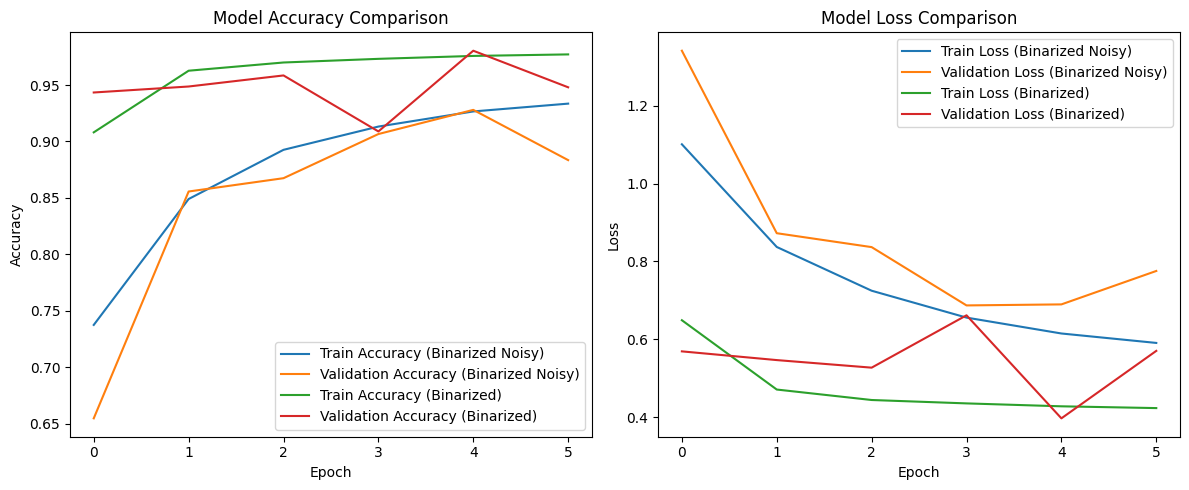

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for both models
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy (Binarized Noisy)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Binarized Noisy)')
plt.plot(history_b.history['accuracy'], label='Train Accuracy (Binarized)')
plt.plot(history_b.history['val_accuracy'], label='Validation Accuracy (Binarized)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (Binarized Noisy)')
plt.plot(history.history['val_loss'], label='Validation Loss (Binarized Noisy)')
plt.plot(history_b.history['loss'], label='Train Loss (Binarized)')
plt.plot(history_b.history['val_loss'], label='Validation Loss (Binarized)')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Visualize the full training history

1. **Training and Validation Accuracy**: Shows how well the model performs on the training and validation sets in terms of classification accuracy.
2. **Training and Validation Loss**: Displays the loss values over epochs, providing insight into how well the model is learning and whether it might be overfitting.